In [140]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')
sys.path.append('../third_party')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import numpy as np   
import pandas as pd
import scipy.stats as stats
import sys
from tqdm import tqdm

from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from missingness_estimation import *

In [142]:
r = 5
seed = 1

# Fixed data parameters
max_test_queries = 100            
max_calib_queries = 2000
matrix_generation_seed = 2024    # Data matrix is fixed 

n1 = n2 = 300

model = "RFM"
solver = "pmf"
r_solver = 8
prop_obs = 0.3

# Other parameters
verbose = True
allow_inf = False
alpha = 0.1

scale=1
const=1


k_list = [5]
repetition = 1

In [143]:
#################
# Generate Data #
#################
if model == "RFM":
    mm = RandomFactorizationModel(n1 ,n2, 8)
elif model == "ROM":
    mm = RandomOrthogonalModel(n1 ,n2, 8)
else:
    mm = RandomFactorizationModel(n1 ,n2, 8)

if verbose:
    print('Fixing the ground truth matrix generated from the {} model.\n'.format(model))
    sys.stdout.flush()

U, V, M = mm.sample_noiseless(matrix_generation_seed)

Fixing the ground truth matrix generated from the RFM model.



In [148]:
#####################
# Define Experiment #
#####################
def run_single_experiment(M_true, k, alpha, prop_obs, max_test_queries, max_calib_queries,
                          r, scale, random_state=0):
    res = pd.DataFrame({})


    #--------Observation bias-------#
    #-------------------------------#
    n1, n2 = M_true.shape
    bm = SamplingBias(n1,n2, normalize=False)
    w_obs = bm.block_weights(ratio=alpha, scale=scale, random_state=random_state)

    #-------Generate masks----------#
    #-------------------------------#
    sampler = QuerySampling(n1,n2)
    mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, w=w_obs, random_state=random_state)
    n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)

    print(f"Estimating missingness with guessed rank {r}...")
    w_obs_est = estimate_P(mask_obs, 1, r=r, const=const)
    print("Done estimating!\n")
    sys.stdout.flush()

    #------Sample test queries------#
    #-------------------------------#
    n_test_queries = min(int(0.99 * np.sum(np.sum(mask_test, axis=1) // k)), max_test_queries)
    _, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)  
    if verbose:
        print("Training size:{}, calib size: {}, test size: {}\n".format(np.sum(mask_obs)-n_calib_queries*k, n_calib_queries, n_test_queries))
        sys.stdout.flush()


    #------Split train calib--------#
    #-------------------------------#
    mask_train, idxs_calib, _ = sampler.sample_train_calib(mask_obs, k, 
                                calib_size=n_calib_queries, random_state=random_state)

    #--------Model Training---------#
    #-------------------------------#
    print("Running matrix completion algorithm on the splitted training set...")
    sys.stdout.flush()
    if solver == "pmf":
        Mhat, _, _ = pmf_solve(M, mask_train, k=r_solver, verbose=verbose, random_state=random_state)
    elif solver == "svt":
        Mhat = svt_solve(M, mask_train, verbose = verbose, random_state = random_state)
    print("Done training!\n")
    sys.stdout.flush()

    pdb.set_trace()
    #------Compute intervals--------# 
    #-------------------------------#
    # Evaluate the CI and quantile inflation weights using oracle obs sampling weights
    ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs)
    df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf, store_weights=True)
    lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, metric='mean',method="conformal")])
    
    # Evaluate the CI and quantile inflation weights using estimated obs sampling weights
    ci_est = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs_est)
    df = ci_est.get_CI(idxs_test, alpha, allow_inf=allow_inf, store_weights=True)
    lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, metric='mean',method="est")])

    # Evaluate the estimation gap
    weights_list = ci_method.weights_list
    est_weights_list = ci_est.weights_list
    est_gaps =[0.5*np.sum(np.abs(weights_list[i]-est_weights_list[i])) for i in range(len(weights_list))]
    avg_gap = np.mean(est_gaps)


    res['k'] = k 
    res['avg_gap'] = avg_gap   
    res['Calib_queries'] = n_calib_queries
    res['Train_entries'] = np.sum(mask_train)
    res['Test_queries'] = n_test_queries
    res['random_state'] = random_state
    return res

k:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Estimating missingness with guessed rank 5...
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
Function value changing by less than progTol
Done estimating!

Training size:17000, calib size: 2000, test size: 100

Running matrix completion algorithm on the splitted training set...
Iteration: 1; Mean diff: 0.0113
Iteration: 2; Mean diff: 0.0062
Iteration: 3; Mean diff: 0.0051
Iteration: 4; Mean diff: 0.0034
Iteration: 5; Mean diff: 0.0024
Iteration: 6; Mean diff: 0.0031
Iteration: 7; Mean diff: 0.0028
Iteration: 8; Mean diff: 0.0024
Iteration: 9; Mean diff: 0.0021
Iteration: 10; Mean diff: 0.0019
Iteration: 11; Mean diff: 0.0016
Iteration: 12; Mean diff: 0.0013
Iteration: 13; Mean diff: 0.0011
Iteration: 14; Mean diff: 0.0009
Iteration: 15; Mean diff: 0.0007
Iteration: 16; Mean diff: 0.0006
Iteration: 17; Mean diff: 0.0005
Iteration: 18; Mean diff: 0.0004
Iteration: 19; Mean diff: 0.0004
Iteration: 20; Mean diff: 0.0003
Iteration: 21; Mean diff: 0.0003
Iteration: 22; Mean diff: 0.

ipdb>  abs_error=np.abs(M-Mhat)
ipdb>  np.max(abs_error)


238.47268540603955


ipdb>  st_error=np.sort(abs_error)
ipdb>  st_error[:10,]


array([[1.26813044e-03, 1.36624284e-03, 1.68469236e-03, ...,
        2.21529160e+00, 2.37000794e+00, 2.51928581e+00],
       [5.54841740e-04, 1.00550383e-03, 1.07928281e-03, ...,
        1.06699126e+00, 1.22011176e+00, 1.45633018e+00],
       [2.06885232e-04, 3.15517805e-04, 1.07185129e-03, ...,
        1.48260457e+00, 1.65836699e+00, 3.38272340e+00],
       ...,
       [5.04918735e-04, 8.82434549e-04, 1.58238584e-03, ...,
        1.68213564e+00, 1.69074844e+00, 1.85404840e+00],
       [7.81883239e-04, 1.42384540e-03, 1.99727049e-03, ...,
        1.44736910e+00, 1.45934858e+00, 1.85255117e+00],
       [7.75578029e-04, 2.02094819e-03, 2.12070836e-03, ...,
        2.22248551e+00, 2.46207658e+00, 5.22765114e+00]])


ipdb>  st_error=np.sort(abs_error.flatten())
ipdb>  st_error[:10,]


array([1.12238868e-06, 1.17171943e-06, 9.81122902e-06, 1.18422790e-05,
       1.48880692e-05, 1.53923977e-05, 2.13961910e-05, 2.19903669e-05,
       2.21952427e-05, 2.33173269e-05])


ipdb>  len(st_error)


90000


ipdb>  st_error[-10:]


array([147.08772997, 150.2350818 , 150.6002389 , 154.81500348,
       155.9911752 , 160.39066022, 171.3777004 , 193.76767636,
       208.68365121, 238.47268541])


ipdb>  st_error[-100:]


array([ 59.48848362,  59.72337166,  59.98976688,  60.57024964,
        61.25988508,  61.55882608,  61.69753601,  61.87170067,
        62.22750018,  62.79400974,  62.82376822,  63.7140636 ,
        63.73282804,  63.78550341,  63.93912182,  64.5519541 ,
        65.0250892 ,  65.12807261,  65.28165291,  66.21761226,
        66.72704538,  67.77652024,  68.09658306,  69.62749021,
        69.94256752,  70.27147151,  71.08602026,  71.24570514,
        71.27522382,  71.4222057 ,  73.80518944,  74.85056493,
        78.42006011,  81.98924925,  82.29645352,  83.50305094,
        83.76998402,  83.85573092,  84.32565618,  84.33604986,
        86.47093676,  86.47309443,  87.05265543,  87.64955438,
        88.13713681,  88.94132684,  90.51134255,  91.63737762,
        93.20284282,  94.70001843,  94.857128  ,  98.10512915,
        98.37387759,  99.13336871,  99.93269148, 100.4653572 ,
       102.53860382, 102.93216462, 103.92960742, 105.18867721,
       105.35162022, 106.59743727, 107.09373663, 107.56

ipdb>  plt.hist(st_error)


(array([8.9823e+04, 6.0000e+01, 4.7000e+01, 2.1000e+01, 2.2000e+01,
       1.5000e+01, 8.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]), array([1.12238868e-06, 2.38472696e+01, 4.76945380e+01, 7.15418064e+01,
       9.53890748e+01, 1.19236343e+02, 1.43083612e+02, 1.66930880e+02,
       1.90778149e+02, 2.14625417e+02, 2.38472685e+02]), <BarContainer object of 10 artists>)


ipdb>  plt.show()


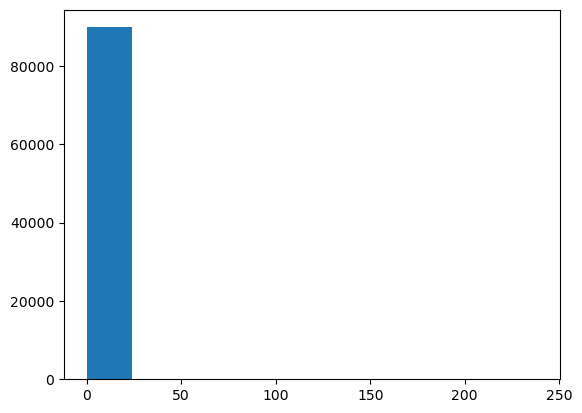

ipdb>  np.sum(st_error>20)


189


ipdb>  np.sum(st_error>1)


3696


ipdb>  q


Repetitions:   0%|                                                                               | 0/1 [21:56<?, ?it/s]


In [151]:
#####################
#  Run Experiments  #
#####################
results = pd.DataFrame({})

for i in tqdm(range(1, repetition+1), desc="Repetitions", leave=True, position=0):
    #random_state = repetition * (seed-1) + i
    random_state=280
    for k in tqdm(k_list, desc="k", leave=True, position=0):

        res = run_single_experiment(M, k, alpha, prop_obs, max_test_queries, max_calib_queries,
                            r, scale=scale, random_state=random_state)
        
        results = pd.concat([results, res])

In [146]:
results

,Query_coverage,Coverage,Size,metric,Inf_prop,Method,k,avg_gap,Calib_queries,Train_entries,Test_queries,random_state
0,0.89,0.97,3.029717,mean,0.0,conformal,5,0.181221,2000,17000,100,280
0,0.89,0.97,3.121167,mean,0.0,est,5,0.181221,2000,17000,100,280
